<center><img src='https://drive.google.com/uc?export=view&id=1qJ8NqAZolTBQY7lN-deZ8xEsU3dlUiLz' width=200></center>


<h6><center></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Agent and Multi-Agent Systems </center>
    <center> PW2 : Multi-Agent Based Simulation</center>
<hr style=" border:none; height:3px;">
</h1>

As we have seen, simulation creates a digital environment that looks like an artificial laboratory where we can test hypotheses, prospective scenarios or simply the evolution of the system in the future.

As with any laboratory experiment, it is necessary to be able to follow the evolution of the experiments: with Multi-Agent based Simulation, it is necessary to visualize the evolution of the simulation and to collect data.

The visualization of the simulation is very important in the context of Multi-Agent based Simulation because the simple and localized rules that allow to reproduce complex and global behaviors of the system are also responsible of the emergence of many phenomena. You can learn more about the emergence capabilities of multi-agent systems at this [address](https://medium.com/scalian/dynamiques-locales-cons%C3%A9quences-globales-97a2ef44ba58)

In what follows, we will present the two features of Mesa that make it possible to make data collection and visualization.

## Part1: Tutorial

### 1. Collecting Data

Mesa provides a class which can handle data collection and storage at runtime, which avoids to manipulates tables or dictionaries manually in the model. All this is done via the `DataCollector` class:

In [1]:
#Do not execute
from mesa.datacollection import DataCollector

The data collector stores three categories of data: *model-level* variables, *agent-level* variables, and *tables* (which are a catch-all for everything else). Model- and agent-level variables are added to the data collector along with a function for collecting them. Model-level collection functions take a model object as an input, while agent-level collection functions take an agent object as an input. Both then return a value computed from the model or each agent at their current state. 

When the data collector’s `collect` method is called, with a model object as its argument, it applies each model-level collection function to the model, and stores the results in a dictionary, associating the current value with the current step of the model. Similarly, the method applies each agent-level collection function to each agent currently in the schedule, associating the resulting value with the step of the model, and the agent’s `unique_id`.

Let’s start from the previous example: the Money Model.

#### Agent-level

First, let us consider an agent-level variable. Imagine we want to store the value of each agent’s wealth at each time step. We must add in the `MoneyModel` constructor a `DataCollector` with the parameter `agent_reporters` set to a dictionary that associates the label of the data and the name of the collected variable:

In [2]:
#Do not execute
self.datacollector = DataCollector(agent_reporters={"Wealth": "wealth"})

NameError: name 'self' is not defined

We now simply tell the model to collect data with

In [ ]:
#Do not execute
self.datacollector.collect(self)

each time we want to store values (e.g. right before or after we call `self.schedule.step()`).

Once the execution is finished, we can retrieve the data with:

In [ ]:
#Do not execute
model.datacollector.get_agent_vars_dataframe()

The result is a Pandas `DataFrame`. See the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html) for more information. You might also want to refer to the [user guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html) for information about Pandas’ data visualization.

<div class="alert alert-block alert-info"> 

 <b>Questions</b>
    
- Update the following code (MoneyModel) by adding this data collector to your model. 

- visualize the health value of one or several agents.
</div> 

In [1]:
#MoneyModel

from mesa.datacollection import DataCollector

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_positions = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_positions)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        
        # Adding datacollector
        self.datacollector = DataCollector(agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

model = MoneyModel(50, 10, 10)  # 50 agents in our example
for i in range(100):
    model.step()

In [2]:
#we can get the agent-wealth data:

agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
1    0             1
     1             1
     2             0
     3             1
     4             1

<AxesSubplot:>

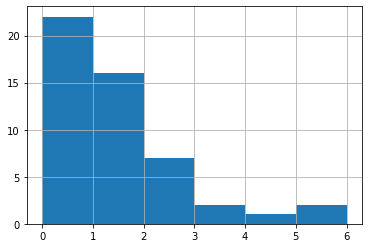

In [3]:
#to get a histogram of agent wealth at the model’s end:

end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

<AxesSubplot:xlabel='Step'>

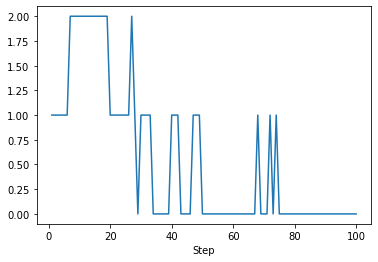

In [4]:
#to plot the wealth of a given agent (you can choose agent 14):

one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

#### Model-level

It is also possible to use functions in the collector. For example, assume we want to collect the value of the Gini Coefficient, a measure of wealth inequality, at each time step on the model. Let’s define the `compute_gini` method:

In [14]:
#Do not execute
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

Now, we can collect this data at runtime using the `DataCollector` with the parameter `model_reporters` set to a dictionary that associates the label of the data and the above function:

In [ ]:
#Do not execute

self.datacollector = DataCollector(
    model_reporters={"Gini": compute_gini},
    agent_reporters={"Wealth": "wealth"})

#Note that we still collect the agents’ wealth values.

<div class="alert alert-block alert-info"> 

 <b>Questions</b>
    
Complete the following code to visualize the evolution of the Gini Coefficient in the simulation. What do you observe ?

</div> 

In [7]:
#Complete the following code

from mesa.datacollection import DataCollector

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid


def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_positions = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_positions)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height, density):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        # Adding datacollector
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"}
        )
    
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

<AxesSubplot:>

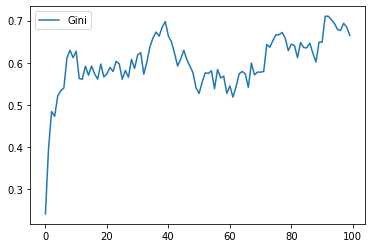

In [2]:
#To get the series of Gini coefficients as a pandas DataFrame:

gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

### 2. Dynamic visualization

So far, we’ve built a model, run it, and analyzed some output afterwards. However, one of the advantages of agent-based models is that we can often watch them run step by step, potentially spotting unexpected patterns, behaviors or bugs, or developing new intuitions, hypotheses, or insights. Other times, watching a model run can explain it to an unfamiliar audience better than static explanations. Like many ABM frameworks, Mesa allows you to create an interactive visualization of the model. In what follows we’ll walk through creating a visualization using built-in components.

First, a quick explanation of how Mesa’s interactive visualization works. Visualization is done in a browser window, using JavaScript to draw the different things being visualized at each step of the model. To do this, Mesa launches a small web server, which runs the model, turns each step into a JSON object (essentially, structured plain text) and sends those steps to the browser.

A visualization is built up of a few different modules: for example, a module for drawing agents on a grid, and another one for drawing a chart of some variable. Each module has a Python part, which runs on the server and turns a model state into JSON data; and a JavaScript side, which takes that JSON data and draws it in the browser window. Mesa comes with a few modules built in, and let you add your own as well.


#### Grid Visualization

To start with, let's have a visualization where we can watch the agents moving around the grid. For this, you will need to put your model code in a separate Python source file; for example, `Money_Model.py`. Next, either in the same file or in a new one (e.g. `Money_Model_Viz`.py) import the `server` class and the `CanvasGrid` class (so-called because it uses HTML5 canvas to draw a grid). If you’re in a new file, you’ll also need to import the actual model object.

In [3]:
#Do not execute

from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

#Do not forget to execute the Money Model for the next questions. 

`CanvasGrid` works by looping over every cell in a grid, and generating a portrayal for every agent it finds. 


A portrayal is a dictionary (which can easily be turned into a JSON object) which tells the JavaScript side how to draw it. The only thing we need to provide is a function which takes an agent, and returns a portrayal object. Here’s the simplest one: it’ll draw each agent as a red, filled circle which fills half of each cell.

In [23]:
#Do not execute
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Color": "red",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5}
    return portrayal

In addition to the portrayal method, we instantiate a canvas grid with its width and height in cells, and in pixels. In this case, let’s create a 10 x 10 grid, drawn in 500 x 500 pixels.

In [24]:
#Do not execute
grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

Now we create and launch the actual server. We do this with the following arguments:

- The model class we’re running and visualizing; in this case, MoneyModel.
- A list of module objects to include in the visualization; here, just `[grid]`.
- The title of the model: "Money Model".
- Any inputs or arguments for the model itself. In this case, 100 agents, and height and width of 10.

Once we create the server, we set the port for it to listen on (you can treat this as just a piece of the URL you’ll open in the browser). Finally, when you’re ready to run the visualization, use the server’s `launch()` method.

In [25]:
#Do not execute
server = ModularServer(MoneyModel,
                   [grid],
                   "Money Model",
                   {"N":100, "width":10, "height":10})
server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}


The full code should now look like:

In [4]:
#You can now execute :-) 

from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red",
                 "r": 0.5}
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N":5, "width":10, "height":10})
server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}


<div class="alert alert-block alert-danger">
    
**Warning**: if you have the following error: **[Errno 48] Address already in use**

It seems that even after closing your browser, the process may continue to run in the background. So you need to kill it. 


</div>

#### Changing the agents

In the visualization above, all we could see is the agents moving around – but not how much money they had, or anything else of interest. Let’s change it so that agents who are broke (wealth 0) are drawn in grey, smaller, and above agents who still have money.

To do this, we go back to our agent_portrayal code and add some code to change the portrayal based on the agent properties.

In [3]:
#This one also can be executed

from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(MoneyModel,
                       [grid],
                       "Money Model",
                       {"N":100, "width":10, "height":10})

server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}


<div class ="alert alert-block alert-success">

**Note** : Initially the result looks the same, but advance the model and smaller grey circles start to appear. Note that since the zero-wealth agents have a higher layer number, they are drawn on top of the red agents.
    </div>

#### Adding a chart

Next, let’s add another element to the visualization: a chart, tracking the model’s Gini Coefficient. This is another built-in element that Mesa provides.

In [ ]:
#Do not execute
from mesa.visualization.modules import ChartModule

The basic chart pulls data from the model’s `DataCollector`, and draws it as a line graph using the `Charts.js` JavaScript libraries. We instantiate a chart element with a list of series for the chart to track. Each series is defined in a dictionary, and has a Label (which must match the name of a model-level variable collected by the DataCollector) and a Color name. We can also give the chart the name of the `DataCollector` object in the model.

Finally, we add the chart to the list of elements in the server. The elements are added to the visualization in the order they appear, so the chart will appear underneath the grid.

In [ ]:
#Do note execute

chart = ChartModule([{"Label": "Gini",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

server = ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N":100, "width":10, "height":10})

Launch the visualization and start a model run, and you’ll see a line chart underneath the grid. Every step of the model, the line chart updates along with the grid. Reset the model, and the chart resets too.

In [2]:
# You can excute this cell 
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

chart = ChartModule([{"Label": "Gini",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

server = ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}


#### User settable parameter

The last part of the tutorial helps you to create a visualization interface in order to see the evolution of the ABM in the simulation. To allow faster modification of model parameters, it is possible to use `UserSettableParameter`. `UserSettableParameter` means that the user can modify this parameter in the web page. It takes 6 parameters (type, name, initial value, min value, max value, value per step).


Let’s start by importing the right mesa packages:

In [3]:
#To execute

from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement
from mesa.visualization.UserParam import UserSettableParameter

Then, add the following line in the definition of the `ModularServer`:

In [4]:
"density": UserSettableParameter("slider", "Agent density", 0.8, 0.1, 1.0, 0.1),

SyntaxError: invalid syntax (<ipython-input-4-cb495d6a7b86>, line 1)

The call of the `ModularServer` became:

In [ ]:
server = ModularServer(MoneyModel,
                   [grid, chart],
                   "Money Model",
                   {"width":10, "height":10, "density": UserSettableParameter("slider", "Agent density", 0.8, 0.1, 1.0, 0.1)})

<div class ="alert alert-block alert-success">

**Note** : to be used in the visualization interface, the density should be defined in the MoneyModel.
    
</div>    

In [9]:
# You can excute this cell 
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)

chart = ChartModule([{"Label": "Gini",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

server = ModularServer(MoneyModel,
                   [grid, chart],
                   "Money Model",
                   {"N":100, "width":10, "height":10, "density": UserSettableParameter("slider", "Agent density", 0.8, 0.1, 1.0, 0.1)})
server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"submit_params","param":"density","value":0.7}
{"type":"submit_params","param":"density","value":0.6}
{"type":"submit_params","param":"density","value":0.5}
{"type":"submit_params","param":"density","value":0.4}
{"type":"submit_params","param":"density","value":0.3}
{"type":"submit_params","param":"density","value":0.2}
{"type":"submit_params","param":"density","value":0.1}
{"type":"submit_params","param":"density","value":0.2}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":1